<a href="https://colab.research.google.com/github/Donghao1997/ESE546public/blob/main/haodong_hw2_problem4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Tensorboard setup

Go to the link generated by the code to look at the training loss curve, you can add accuracy and other things to the plot. Refer to the recitation 2 code for referance.

In [1]:
LOG_DIR = './logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

!if [ -f ngrok ] ; then echo "Ngrok already installed" ; else wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip > /dev/null 2>&1 && unzip ngrok-stable-linux-amd64.zip > /dev/null 2>&1 ; fi


In [2]:
get_ipython().system_raw('./ngrok http 6006 &')

In [3]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print('Tensorboard Link: ' +str(json.load(sys.stdin)['tunnels'][0]['public_url']))"

Tensorboard Link: http://43bf-34-140-77-142.ngrok.io


In [4]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import tensorflow as tf
import numpy as np
import scipy.misc 
try:
    from StringIO import StringIO  # Python 2.7
except ImportError:
    from io import BytesIO         # Python 3.x

In [5]:
# Code referenced from https://gist.github.com/gyglim/1f8dfb1b5c82627ae3efcfbbadb9f514

class Logger(object):
    
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.FileWriter(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        self.writer.add_summary(summary, step)

    def image_summary(self, tag, images, step):
        """Log a list of images."""

        img_summaries = []
        for i, img in enumerate(images):
            # Write the image to a string
            try:
                s = StringIO()
            except:
                s = BytesIO()
            scipy.misc.toimage(img).save(s, format="png")

            # Create an Image object
            img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                       height=img.shape[0],
                                       width=img.shape[1])
            # Create a Summary value
            img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))

        # Create and write Summary
        summary = tf.Summary(value=img_summaries)
        self.writer.add_summary(summary, step)
        
    def histo_summary(self, tag, values, step, bins=1000):
        """Log a histogram of the tensor of values."""

        # Create a histogram using numpy
        counts, bin_edges = np.histogram(values, bins=bins)

        # Fill the fields of the histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values**2))

        # Drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        # Create and write Summary
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
        self.writer.add_summary(summary, step)
        self.writer.flush()

  

In [6]:
# torch and torchvision imports
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() #Use the v1 compatibility package in 2.0 to follow the 1.x code
logger = Logger('./logs')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')     

Instructions for updating:
non-resource variables are not supported in the long term


# Training Loop on CIFAR 10.


 The model currently does not achieve less than 12% validation error, you have to tweak the parameters to get it.

In [7]:
# Reading in the dataset
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))],)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# **Problem(a)**

In [8]:
# Defining the model
class View(nn.Module):
    def __init__(self,o):
        super().__init__()
        self.o = o

    def forward(self,x):
        return x.view(-1, self.o)
    
class allcnn_t(nn.Module):
    def __init__(self, c1=96, c2= 192):
        super().__init__()
        d = 0.5

        def convbn(ci,co,ksz,s=1,pz=0):
            return nn.Sequential(
                nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
                nn.ReLU(True),
                nn.BatchNorm2d(co))

        self.m = nn.Sequential(
            nn.Dropout(0.2),
            convbn(3,c1,3,1,1),
            convbn(c1,c1,3,1,1),
            convbn(c1,c1,3,2,1),
            nn.Dropout(d),
            convbn(c1,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,2,1),
            nn.Dropout(d),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,10,1,1),
            nn.AvgPool2d(8),
            View(10))

        print('Num parameters: ', sum([p.numel() for p in self.m.parameters()]))

    def forward(self, x):
        return self.m(x)

# The training loop

def train(net, optimizer, criterion, train_loader, test_loader, epochs, model_name, plot):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    for epoch in range(epochs):
        correct = 0
        total = 0
        
        #Learning rate of 0.1 for the first 40 epochs, then 0.01 for the next 40 epochs and then 0.001 for the final 20 epochs.
        if (0 <= epoch < 40):
          optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
        elif (epoch < 80):
          optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
        elif (epoch <= 100):
          optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
        
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)
            #Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 1000 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
            if plot:
              info = { ('loss_' + model_name): loss.item() }
              for tag, value in info.items():
                logger.scalar_summary(tag, value, overall_step+1)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(test_loader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))

The validation error below 10%

In [ ]:
model = allcnn_t().to(device)
#TODO: Set it as number of epochs states in the question
epochs = 100
# TODO: Define the loss function as asked in the question
criterion = nn.CrossEntropyLoss()
# TODO: Set parameters as stated in the question
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
# Training loop called here
train(model, optimizer, criterion, trainloader, testloader, epochs, 'cnn', True)

Num parameters:  1667166
Epoch [1/100], Step [1000/3125], Loss: 1.6261
Epoch [1/100], Step [2000/3125], Loss: 1.7529
Epoch [1/100], Step [3000/3125], Loss: 2.0723
Epoch [2/100], Step [1000/3125], Loss: 1.1904
Epoch [2/100], Step [2000/3125], Loss: 0.9193
Epoch [2/100], Step [3000/3125], Loss: 1.2091
Epoch [3/100], Step [1000/3125], Loss: 1.0505
Epoch [3/100], Step [2000/3125], Loss: 0.7018
Epoch [3/100], Step [3000/3125], Loss: 0.7726
Epoch [4/100], Step [1000/3125], Loss: 1.4858
Epoch [4/100], Step [2000/3125], Loss: 1.2573
Epoch [4/100], Step [3000/3125], Loss: 0.9117
Epoch [5/100], Step [1000/3125], Loss: 1.3506
Epoch [5/100], Step [2000/3125], Loss: 0.4374
Epoch [5/100], Step [3000/3125], Loss: 0.3397
Epoch [6/100], Step [1000/3125], Loss: 0.5020
Epoch [6/100], Step [2000/3125], Loss: 0.7247
Epoch [6/100], Step [3000/3125], Loss: 0.5926
Epoch [7/100], Step [1000/3125], Loss: 0.3005
Epoch [7/100], Step [2000/3125], Loss: 0.4931
Epoch [7/100], Step [3000/3125], Loss: 0.8924
Epoch [8/

Plot the training and validation losses and errors as a function of the number of epochs.

In [13]:
#define a training function of ploting
def train_for_plot(net, criterion, train_loader, test_loader, epochs, model_name, plot):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    train_loss = []
    val_loss = []
    train_error = []
    val_error = []
    ep = []
    for epoch in range(epochs):
        ep.append(epoch+1)
        correct = 0
        total = 0
        total_loss_t = 0
        total_error_t = 0
        #Learning rate of 0.1 for the first 40 epochs, then 0.01 for the next 40 epochs and then 0.001 for the final 20 epochs.
        if (0 <= epoch < 40):
          optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
        elif (epoch < 80):
          optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
        elif (epoch <= 100):
          optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)
            #Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (i+1) % 1000 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
            if plot:
              info = { ('loss_' + model_name): loss.item() }
              for tag, value in info.items():
                logger.scalar_summary(tag, value, overall_step+1)

            total += labels.size(0)
            total_loss_t += loss.item()
            total_error_t += (predicted != labels).sum().item()
        train_loss.append(total_loss_t)
        train_error.append(total_error_t/total*100)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            total_loss_v = 0
            total_error_v = 0
            for i, (images, labels) in enumerate(test_loader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                total_loss_v += loss.item()
                total_error_v += (predicted != labels).sum().item()
            val_loss.append(total_loss_v)
            val_error.append(total_error_v/total*100)

    print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
    return train_loss, val_loss, train_error, val_error, ep

Using 25 epoches to plot.

In [28]:
model = allcnn_t().to(device)
epochs = 25
criterion = nn.CrossEntropyLoss()

Num parameters:  1667166


In [29]:
#using to plot
train_loss, val_loss, train_error, val_error, ep = train_for_plot(model, criterion, trainloader, testloader, epochs, 'cnn', True)

Epoch [1/25], Step [1000/3125], Loss: 1.5512
Epoch [1/25], Step [2000/3125], Loss: 1.4096
Epoch [1/25], Step [3000/3125], Loss: 1.2429
Epoch [2/25], Step [1000/3125], Loss: 1.1471
Epoch [2/25], Step [2000/3125], Loss: 1.1909
Epoch [2/25], Step [3000/3125], Loss: 0.8490
Epoch [3/25], Step [1000/3125], Loss: 0.9430
Epoch [3/25], Step [2000/3125], Loss: 1.1152
Epoch [3/25], Step [3000/3125], Loss: 1.2824
Epoch [4/25], Step [1000/3125], Loss: 1.1282
Epoch [4/25], Step [2000/3125], Loss: 0.6656
Epoch [4/25], Step [3000/3125], Loss: 0.4334
Epoch [5/25], Step [1000/3125], Loss: 0.4997
Epoch [5/25], Step [2000/3125], Loss: 0.4362
Epoch [5/25], Step [3000/3125], Loss: 0.5105
Epoch [6/25], Step [1000/3125], Loss: 0.8612
Epoch [6/25], Step [2000/3125], Loss: 1.1902
Epoch [6/25], Step [3000/3125], Loss: 0.7797
Epoch [7/25], Step [1000/3125], Loss: 0.4895
Epoch [7/25], Step [2000/3125], Loss: 0.7134
Epoch [7/25], Step [3000/3125], Loss: 0.6674
Epoch [8/25], Step [1000/3125], Loss: 0.4165
Epoch [8/2

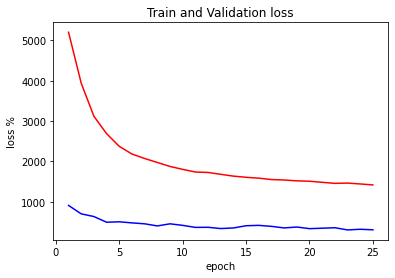

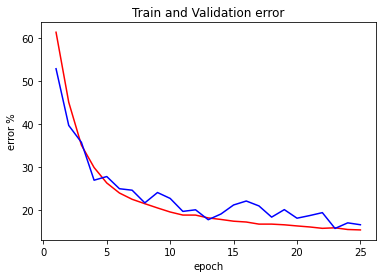

In [30]:
#plot the image
plt.plot(ep, train_loss, 'r', label='train loss')
plt.plot(ep, val_loss, 'b', label='validation loss')
plt.title('Train and Validation loss')
plt.xlabel('epoch')
plt.ylabel('loss %')
plt.show()

plt.plot(ep, train_error, 'r', label='train error')
plt.plot(ep, val_error, 'b', label='validation error')
plt.title('Train and Validation error')
plt.xlabel('epoch')
plt.ylabel('error %')
plt.show()

In [31]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [18]:
#model saved
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

# **Problem(b)**

Plot this gradient for a few input images which the network classifies correctly and also for a few images which the network misclassifies.

In [32]:
trainloader_100 = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
xs = []
ys = []
eps = 8

for i, (images, labels) in enumerate(trainloader_100):
    if i == 1:
        break
    xs.append(images)
    ys.append(labels)

test the matrix

In [33]:
len(xs[0])

100

In [34]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
True_i = []
False_i = []
for x, y in zip(xs,ys):
  x = x.to(device)
  y = y.to(device)
  x.requires_grad_(True)
  yh = model(x)
  loss = criterion(yh,y)
  optimizer.zero_grad()
  loss.backward()
  _, predicted = torch.max(yh.data,1)
  outcome = predicted == y
  dx = x.grad.data.clone() 
  for i in range(100):
    if outcome[i] == True:
      True_i.append(i)
    else:
      False_i.append(i)

In [35]:
outcome

tensor([ True,  True,  True, False,  True, False,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True, False,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')

In [36]:
dx = dx.cpu()

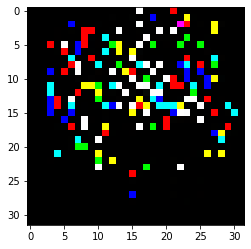

In [37]:
#chose True one from the outcome
import random
import matplotlib.pyplot as plt
a = random.choice(True_i)
aa = (dx.detach().numpy())[a] #transform tensor to numpy
aa = aa.transpose((1,2,0)) #（channels,imagesize,imagesize）
aa = (aa-np.mean(aa))/np.std(aa) #normalize
aa = np.uint8(aa)
plt.imshow(aa)

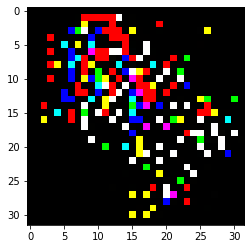

In [38]:
#chose Fals one from the outcome, eg:outcome[2]
b = random.choice(False_i)
bb = (dx.detach().numpy())[b] #transform tensor to numpy
bb = bb.transpose((1,2,0)) #（channels,imagesize,imagesize）
bb = (bb-np.mean(bb))/np.std(bb) #normalize
bb = np.uint8(bb)
plt.imshow(bb)

step:0 loss:0.31073594093322754
step:1 loss:4.698543071746826
step:2 loss:10.973986625671387
step:3 loss:16.8492374420166
step:4 loss:21.981725692749023


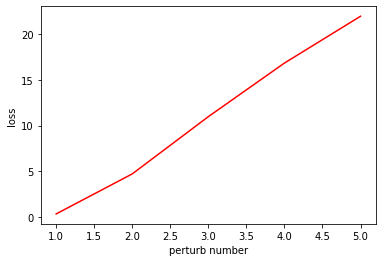

In [39]:
ell = []
number = []
for x,y in zip(xs,ys):
  for k in range(5):
    x.requires_grad_(True)
    x = x.to(device)
    x.retain_grad()
    y = y.to(device)
    yh = model(x)
    loss = criterion(yh, y)
    optimizer.zero_grad()
    loss.backward()
    loss_temp = 0
    dx = x.grad.data.clone()
    dx = torch.sign(dx)
    x = x + (eps/256)*dx
    
    loss_temp = loss.item()
    ell.append(loss_temp)
    number.append(k+1)
    print("step:{} loss:{}".format(k,loss_temp))
  plt.plot(number, ell, 'r')
  plt.xlabel('perturb number')
  plt.ylabel('loss')

# **Problem(c)**

Compute the accuracy of the network on 1-step perturbed images.

In [40]:
model.eval()
o_correct = 0
m_correct = 0
total = 0
for i, (images, labels) in enumerate(testloader):
    x = images.to(device)
    y = labels.to(device)
    x.requires_grad_(True)
    outputs = model(x)
    loss = criterion(outputs, y)
    optimizer.zero_grad()
    loss.backward()
    _, predicted = torch.max(outputs.data, 1)
    o_correct += (predicted == y).sum().item()

    dx = x.grad.data.clone()
    x = torch.add(x, eps*torch.sign(dx))
    x.retain_grad()
    outputs = model(x)
    _, predicted = torch.max(outputs.data, 1)
    total += y.size(0)
    m_correct += (predicted == y).sum().item()

In [41]:
print('Accuracy on the modified test images: {} %'.format(100 * m_correct / total))
print('Accuracy on the original test images: {} %'.format(100 * o_correct / total))

Accuracy on the modified test images: 11.8 %
Accuracy on the original test images: 83.48 %


# **The second way for Question 4** 
maybe the results are not useful.

# **Problem4 (a)** 

In [ ]:
# Reading in the dataset
transform = transforms.Compose([
     transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Defining the model
class View(nn.Module):
    def __init__(self,o):
        super().__init__()
        self.o = o

    def forward(self,x):
        return x.view(-1, self.o)
    
class allcnn_t(nn.Module):
    def __init__(self, c1=96, c2= 192):
        super().__init__()
        d = 0.5

        def convbn(ci,co,ksz,s=1,pz=0):
            return nn.Sequential(
                nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
                nn.ReLU(True),
                nn.BatchNorm2d(co))

        self.m = nn.Sequential(
            nn.Dropout(0.2),
            convbn(3,c1,3,1,1),
            convbn(c1,c1,3,1,1),
            convbn(c1,c1,3,2,1),
            nn.Dropout(d),
            convbn(c1,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,2,1),
            nn.Dropout(d),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,10,1,1),
            nn.AvgPool2d(8),
            View(10))

        print('Num parameters: ', sum([p.numel() for p in self.m.parameters()]))

    def forward(self, x):
        return self.m(x)

# The training loop

def train(net, optimizer, criterion, train_loader, test_loader, epochs, model_name, plot):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    train_loss = []
    train_error = []
    val_loss = []
    val_error = []
    for epoch in range(epochs):
        correct = 0
        total = 0
        loss_save = 0.0
        
        #Learning rate of 0.1 for the first 40 epochs, then 0.01 for the next 40 epochs and then 0.001 for the final 20 epochs.
        if (0 <= epoch < 40):
          optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
        elif (epoch < 80):
          optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
        elif (epoch <= 100):
          optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
        
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)
            #Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            loss_save += loss.item()
            _, predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            optimizer.step()

            if (i+1) % 1000 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
            if plot:
              info = { ('loss_' + model_name): loss.item() }
              for tag, value in info.items():
                logger.scalar_summary(tag, value, overall_step+1)
        train_loss.append(loss_save)
        train_error.append(100-100*correct/total)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(test_loader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss.append(loss_save)
        val_error.append(100-100*correct/total)
    print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
    return val_error,val_loss,train_error,train_loss

In [ ]:
model = allcnn_t().to(device)
#TODO: Set it as number of epochs states in the question
epochs = 100
# TODO: Define the loss function as asked in the question
criterion = nn.CrossEntropyLoss()
# TODO: Set parameters as stated in the question
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
# Training loop called here
val_error,val_loss,train_error,train_loss = train(model, optimizer, criterion, trainloader, testloader, epochs, 'cnn', True)

Num parameters:  1667166
Epoch [1/100], Step [1000/3125], Loss: 1.9898
Epoch [1/100], Step [2000/3125], Loss: 1.6824
Epoch [1/100], Step [3000/3125], Loss: 1.3944
Epoch [2/100], Step [1000/3125], Loss: 1.3690
Epoch [2/100], Step [2000/3125], Loss: 1.1930
Epoch [2/100], Step [3000/3125], Loss: 1.1196
Epoch [3/100], Step [1000/3125], Loss: 0.9548
Epoch [3/100], Step [2000/3125], Loss: 1.4796
Epoch [3/100], Step [3000/3125], Loss: 0.7386
Epoch [4/100], Step [1000/3125], Loss: 0.9032
Epoch [4/100], Step [2000/3125], Loss: 0.9778
Epoch [4/100], Step [3000/3125], Loss: 1.1450
Epoch [5/100], Step [1000/3125], Loss: 1.5697
Epoch [5/100], Step [2000/3125], Loss: 0.7775
Epoch [5/100], Step [3000/3125], Loss: 1.0496
Epoch [6/100], Step [1000/3125], Loss: 0.6613
Epoch [6/100], Step [2000/3125], Loss: 0.5201
Epoch [6/100], Step [3000/3125], Loss: 0.5005
Epoch [7/100], Step [1000/3125], Loss: 0.9614
Epoch [7/100], Step [2000/3125], Loss: 0.9196
Epoch [7/100], Step [3000/3125], Loss: 0.7876
Epoch [8/

In [ ]:
torch.save(model.state_dict(), "model4a.pth")
print("Saved PyTorch Model State to model4a.pth")

Saved PyTorch Model State to model4a.pth


In [ ]:
#model loading
model.load_state_dict(torch.load("model4a.pth"))

<All keys matched successfully>

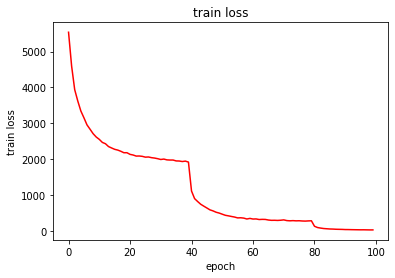

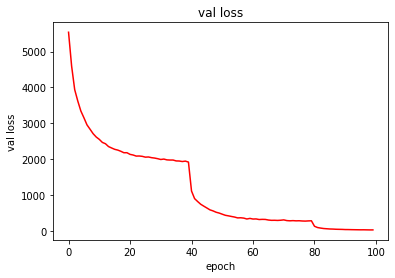

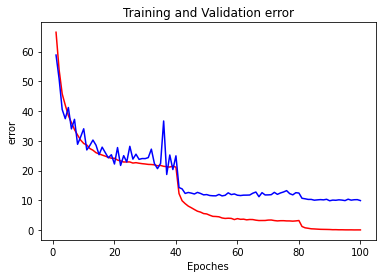

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, 'r')
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.title('train loss')
plt.show()

plt.plot(val_loss, 'r')
plt.xlabel('epoch')
plt.ylabel('val loss')
plt.title('val loss')
plt.show()
epochs = range(1,101)

plt.plot(epochs, train_error, 'r', label='training error')
plt.plot(epochs, val_error, 'b', label='validation error')
plt.title('Training and Validation error')
plt.xlabel('Epoches')
plt.ylabel('error')
plt.show()

# **Problem4 (b)** 

In [ ]:
trainloader_100 = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
xs = []
ys = []
eps = 8

for i, (images, labels) in enumerate(trainloader_100):
    if i == 1:
        break
    xs.append(images)
    ys.append(labels)

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)

for x,y in zip(xs, ys):
    x = x.to(device)
    y = y.to(device)
    x.requires_grad_(True)
    outputs = model(x)
    loss = criterion(outputs, y)
    optimizer.zero_grad()
    loss.backward()
    x.retain_grad()
    _, predicted = torch.max(outputs.data, 1)
    results = predicted == y
    dx = x.grad.data.clone()

In [ ]:
dx = dx.cpu()

In [ ]:
results

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True], device='cuda:0')

tensor(True, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


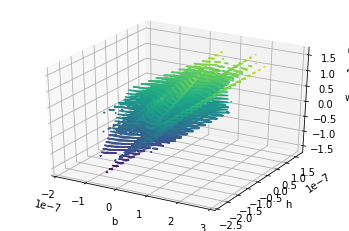

In [ ]:
print(results[15])
ax = plt.axes(projection='3d')
ax.contour3D(dx[15][0], dx[15][1], dx[15][2], 50)
ax.set_xlabel('b')
ax.set_ylabel('h')
ax.set_zlabel('w')
plt.show()

tensor(True, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


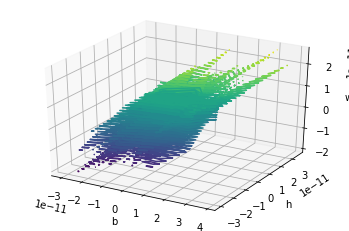

In [ ]:
print(results[83])
ax = plt.axes(projection='3d')
ax.contour3D(dx[83][0], dx[83][1], dx[83][2], 50)
ax.set_xlabel('b')
ax.set_ylabel('h')
ax.set_zlabel('w')
plt.show()

step 1 loss: 0.012147665955126286
step 2 loss: 16.560705184936523
step 3 loss: 114.54875183105469
step 4 loss: 342.1375732421875
step 5 loss: 685.2285766601562


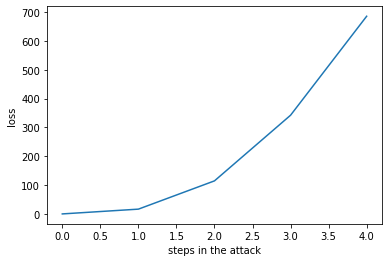

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)
steps = []
losses = []

for x,y in zip(xs, ys):
    x = x.to(device)
    y = y.to(device)
    x.requires_grad_(True)
    outputs = model(x)
    loss = criterion(outputs, y)
    optimizer.zero_grad()
    loss.backward()

    for k in range(5):
        dx = x.grad.data.clone()
        x = torch.add(x, eps*torch.sign(dx))
        x.retain_grad()

        outputs = model(x)
        ell = loss.item()
        steps.append(k)
        losses.append(ell)
        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        print("step " + str(k+1) + " loss: " + str(ell))
    plt.plot(steps, losses)
    plt.xlabel("steps in the attack")
    plt.ylabel("loss")
    plt.show()

# **Problem4 (c)** 

In [ ]:
model.eval()
o_correct = 0
m_correct = 0
total = 0
for i, (images, labels) in enumerate(testloader):
    x = images.to(device)
    y = labels.to(device)
    x.requires_grad_(True)
    outputs = model(x)
    loss = criterion(outputs, y)
    optimizer.zero_grad()
    loss.backward()
    _, predicted = torch.max(outputs.data, 1)
    o_correct += (predicted == y).sum().item()

    dx = x.grad.data.clone()
    x = torch.add(x, eps*torch.sign(dx))
    x.retain_grad()
    outputs = model(x)
    _, predicted = torch.max(outputs.data, 1)
    total += y.size(0)
    m_correct += (predicted == y).sum().item()

In [ ]:
print('Accuracy on the modified test images: {} %'.format(100 * m_correct / total))
print('Accuracy on the original test images: {} %'.format(100 * o_correct / total))

Accuracy on the modified test images: 9.4 %
Accuracy on the original test images: 89.95 %
